In [1]:
! pip install kaggle

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
! mkdir ~/.kaggle

In [5]:
!cp /content/drive/MyDrive/kaggle.json ~/.kaggle/kaggle.json

In [6]:
!kaggle competitions download -c challenges-in-representation-learning-facial-expression-recognition-challenge

 99% 282M/285M [00:11<00:00, 36.5MB/s]
100% 285M/285M [00:11<00:00, 26.4MB/s]


In [7]:
! unzip challenges-in-representation-learning-facial-expression-recognition-challenge

Archive:  challenges-in-representation-learning-facial-expression-recognition-challenge.zip
  inflating: example_submission.csv  
  inflating: fer2013.tar.gz          
  inflating: icml_face_data.csv      
  inflating: test.csv                
  inflating: train.csv               


In [8]:
! tar -xzvf fer2013.tar.gz

fer2013/fer2013.csv
fer2013/README
fer2013/fer2013.bib
fer2013/


In [9]:
import tarfile
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential, Model, model_from_json
from keras.layers import Dense, Conv2D, Activation, MaxPool2D, Flatten, Dropout, BatchNormalization
from keras.utils import np_utils
from keras.callbacks import ModelCheckpoint

%matplotlib inline

In [10]:
df = pd.read_csv("fer2013/fer2013.csv")
df.head()

,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training


In [11]:
X_train = []
y_train = []
X_test = []
y_test = []
for index, row in df.iterrows():
    k = row['pixels'].split(" ")
    if row['Usage'] == 'Training':
        X_train.append(np.array(k))
        y_train.append(row['emotion'])
    elif row['Usage'] == 'PublicTest':
        X_test.append(np.array(k))
        y_test.append(row['emotion'])

In [12]:
X_train = np.array(X_train, dtype = 'uint8')
y_train = np.array(y_train, dtype = 'uint8')
X_test = np.array(X_test, dtype = 'uint8')
y_test = np.array(y_test, dtype = 'uint8')

In [13]:
import keras
from tensorflow.keras.utils import to_categorical
y_train= to_categorical(y_train, num_classes=7)
y_test = to_categorical(y_test, num_classes=7)

In [14]:
X_train = X_train.reshape(X_train.shape[0], 48, 48, 1)
X_test = X_test.reshape(X_test.shape[0], 48, 48, 1)

In [15]:
from keras.preprocessing.image import ImageDataGenerator 
datagen = ImageDataGenerator( 
    rescale=1./255,
    rotation_range = 10,
    horizontal_flip = True,
    width_shift_range=0.1,
    height_shift_range=0.1,
    fill_mode = 'nearest')

testgen = ImageDataGenerator(rescale=1./255)
datagen.fit(X_train)

batch_size=64

In [16]:
train_flow = datagen.flow(X_train, y_train, batch_size=batch_size) 
test_flow = testgen.flow(X_test, y_test, batch_size=batch_size)

In [17]:
from tensorflow.keras.utils import plot_model
from keras.models import Model
from keras.layers import Input, Dense, Flatten, Dropout, BatchNormalization
from keras.layers.convolutional import Conv2D
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from tensorflow.keras.optimizers import Adam, SGD
from keras.regularizers import l1, l2
from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix

In [ ]:
def FER_Model(input_shape=(48,48,1)):
    # first input model
    visible = Input(shape=input_shape, name='input')
    num_classes = 7
    #the 1-st block
    conv1_1 = Conv2D(64, kernel_size=3, activation='relu', padding='same', name = 'conv1_1')(visible)
    conv1_1 = BatchNormalization()(conv1_1)
    conv1_2 = Conv2D(64, kernel_size=3, activation='relu', padding='same', name = 'conv1_2')(conv1_1)
    conv1_2 = BatchNormalization()(conv1_2)
    pool1_1 = MaxPooling2D(pool_size=(2,2), name = 'pool1_1')(conv1_2)
    drop1_1 = Dropout(0.3, name = 'drop1_1')(pool1_1)
    
    #the 2-nd block
    conv2_1 = Conv2D(128, kernel_size=3, activation='relu', padding='same', name = 'conv2_1')(drop1_1)
    conv2_1 = BatchNormalization()(conv2_1)
    conv2_2 = Conv2D(128, kernel_size=3, activation='relu', padding='same', name = 'conv2_2')(conv2_1)
    conv2_2 = BatchNormalization()(conv2_2)
    conv2_3 = Conv2D(128, kernel_size=3, activation='relu', padding='same', name = 'conv2_3')(conv2_2)
    conv2_2 = BatchNormalization()(conv2_3)
    pool2_1 = MaxPooling2D(pool_size=(2,2), name = 'pool2_1')(conv2_3)
    drop2_1 = Dropout(0.3, name = 'drop2_1')(pool2_1)
    
    #the 3-rd block
    conv3_1 = Conv2D(256, kernel_size=3, activation='relu', padding='same', name = 'conv3_1')(drop2_1)
    conv3_1 = BatchNormalization()(conv3_1)
    conv3_2 = Conv2D(256, kernel_size=3, activation='relu', padding='same', name = 'conv3_2')(conv3_1)
    conv3_2 = BatchNormalization()(conv3_2)
    conv3_3 = Conv2D(256, kernel_size=3, activation='relu', padding='same', name = 'conv3_3')(conv3_2)
    conv3_3 = BatchNormalization()(conv3_3)
    conv3_4 = Conv2D(256, kernel_size=3, activation='relu', padding='same', name = 'conv3_4')(conv3_3)
    conv3_4 = BatchNormalization()(conv3_4)
    pool3_1 = MaxPooling2D(pool_size=(2,2), name = 'pool3_1')(conv3_4)
    drop3_1 = Dropout(0.3, name = 'drop3_1')(pool3_1)
    
    #the 4-th block
    conv4_1 = Conv2D(256, kernel_size=3, activation='relu', padding='same', name = 'conv4_1')(drop3_1)
    conv4_1 = BatchNormalization()(conv4_1)
    conv4_2 = Conv2D(256, kernel_size=3, activation='relu', padding='same', name = 'conv4_2')(conv4_1)
    conv4_2 = BatchNormalization()(conv4_2)
    conv4_3 = Conv2D(256, kernel_size=3, activation='relu', padding='same', name = 'conv4_3')(conv4_2)
    conv4_3 = BatchNormalization()(conv4_3)
    conv4_4 = Conv2D(256, kernel_size=3, activation='relu', padding='same', name = 'conv4_4')(conv4_3)
    conv4_4 = BatchNormalization()(conv4_4)
    pool4_1 = MaxPooling2D(pool_size=(2,2), name = 'pool4_1')(conv4_4)
    drop4_1 = Dropout(0.3, name = 'drop4_1')(pool4_1)
    
    #the 5-th block
    conv5_1 = Conv2D(512, kernel_size=3, activation='relu', padding='same', name = 'conv5_1')(drop4_1)
    conv5_1 = BatchNormalization()(conv5_1)
    conv5_2 = Conv2D(512, kernel_size=3, activation='relu', padding='same', name = 'conv5_2')(conv5_1)
    conv5_2 = BatchNormalization()(conv5_2)
    conv5_3 = Conv2D(512, kernel_size=3, activation='relu', padding='same', name = 'conv5_3')(conv5_2)
    conv5_3 = BatchNormalization()(conv5_3)
    conv5_4 = Conv2D(512, kernel_size=3, activation='relu', padding='same', name = 'conv5_4')(conv5_3)
    conv5_3 = BatchNormalization()(conv5_3)
    pool5_1 = MaxPooling2D(pool_size=(2,2), name = 'pool5_1')(conv5_4)
    drop5_1 = Dropout(0.3, name = 'drop5_1')(pool5_1)
    
    #Flatten and output
    flatten = Flatten(name = 'flatten')(drop5_1)
    dense1 = Dense(512, activation='relu', name = 'dense1')(flatten)
    dense2 = Dense(256, activation='relu', name = 'dense2')(dense1)
    dense3 = Dense(128, activation='relu', name = 'dense3')(dense2)
    ouput = Dense(num_classes, activation='softmax', name = 'output')(dense3)
    # create model 
    model = Model(inputs =visible, outputs = ouput)

    return model

In [ ]:
model = FER_Model()
opt = Adam(lr=0.0001, decay=1e-6)
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 48, 48, 1)]       0         
                                                                 
 conv1_1 (Conv2D)            (None, 48, 48, 64)        640       
                                                                 
 batch_normalization_42 (Bat  (None, 48, 48, 64)       256       
 chNormalization)                                                
                                                                 
 conv1_2 (Conv2D)            (None, 48, 48, 64)        36928     
                                                                 
 batch_normalization_43 (Bat  (None, 48, 48, 64)       256       
 chNormalization)                                                
                                                                 
 pool1_1 (MaxPooling2D)      (None, 24, 24, 64)        0   

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


 conv5_1 (Conv2D)            (None, 3, 3, 512)         1180160   
                                                                 
 batch_normalization_55 (Bat  (None, 3, 3, 512)        2048      
 chNormalization)                                                
                                                                 
 conv5_2 (Conv2D)            (None, 3, 3, 512)         2359808   
                                                                 
 batch_normalization_56 (Bat  (None, 3, 3, 512)        2048      
 chNormalization)                                                
                                                                 
 conv5_3 (Conv2D)            (None, 3, 3, 512)         2359808   
                                                                 
 batch_normalization_57 (Bat  (None, 3, 3, 512)        2048      
 chNormalization)                                                
                                                                 
 conv5_4 (

In [ ]:
num_epochs = 100  
history = model.fit_generator(train_flow, 
                    steps_per_epoch=len(X_train) / batch_size, 
                    epochs=num_epochs,  
                    verbose=1,  
                    validation_data=test_flow,
                    validation_steps=len(X_test) / batch_size)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  import sys


Epoch 1/100
448/448 [==============================] - 75s 161ms/step - loss: 1.8141 - accuracy: 0.2437 - val_loss: 1.8686 - val_accuracy: 0.2352
Epoch 2/100
448/448 [==============================] - 71s 159ms/step - loss: 1.7660 - accuracy: 0.2668 - val_loss: 1.8347 - val_accuracy: 0.2655
Epoch 3/100
448/448 [==============================] - 71s 159ms/step - loss: 1.6867 - accuracy: 0.3234 - val_loss: 1.6539 - val_accuracy: 0.3678
Epoch 4/100
448/448 [==============================] - 71s 159ms/step - loss: 1.5890 - accuracy: 0.3747 - val_loss: 1.5108 - val_accuracy: 0.4244
Epoch 5/100
448/448 [==============================] - 71s 159ms/step - loss: 1.5095 - accuracy: 0.4131 - val_loss: 1.4476 - val_accuracy: 0.4405
Epoch 6/100
448/448 [==============================] - 72s 160ms/step - loss: 1.4293 - accuracy: 0.4454 - val_loss: 1.3990 - val_accuracy: 0.4784
Epoch 7/100
448/448 [==============================] - 72s 159ms/step - loss: 1.3602 - accuracy: 0.4768 - val_loss: 1.2793 -

In [ ]:
model_json = model.to_json()
with open("/content/drive/MyDrive/Resume-Apratim Sadhu/model.json", "w") as json_file:
    json_file.write(model_json)
model.save_weights("/content/drive/MyDrive/Resume-Apratim Sadhu/model.h5")
print("Saved model to disk")

Saved model to disk


In [ ]:
model.save("/content/drive/MyDrive/Resume-Apratim Sadhu/HDF5model.h5")

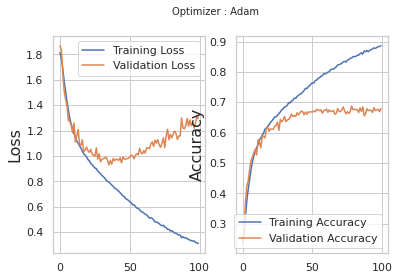

In [ ]:
# plot the evolution of Loss and Acuracy on the train and validation sets
import seaborn as sns
sns.set(style='whitegrid')

# plt.figure(figsize=(20,10))
plt.subplot(1, 2, 1)
plt.suptitle('Optimizer : Adam', fontsize=10)
plt.ylabel('Loss', fontsize=16)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend(loc='upper right')

plt.subplot(1, 2, 2)
plt.ylabel('Accuracy', fontsize=16)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend(loc='lower right')
plt.show()

In [18]:
model_json_file = "model.json"
model_weights_file = "model_weights.h5"

with open(model_json_file, "r") as json_file:
    loaded_model_json = json_file.read()
    model = model_from_json(loaded_model_json)
    model.load_weights(model_weights_file)

In [21]:
#Assigning Names to Emotions in labels

num_classes = 7
width = 48
height = 48
emotion_labels = ["Angry", "Disgust", "Fear", "Happy", "Sad", "Surprise", "Neutral"]
classes=np.array(("Angry", "Disgust", "Fear", "Happy", "Sad", "Surprise", "Neutral"))
df.Usage.value_counts() 

Training       28709
PublicTest      3589
PrivateTest     3589
Name: Usage, dtype: int64

113/113 [==============================] - 3s 28ms/step


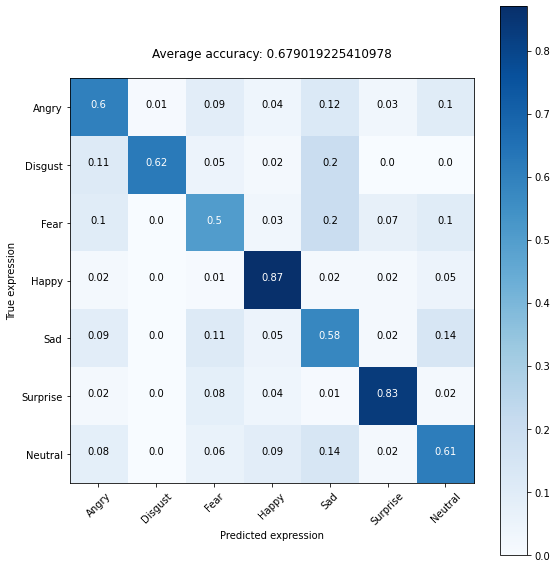

In [32]:
import itertools
plt.figure(figsize=(8,8))
def plot_confusion_matrix(y_test, y_pred, classes,
                          normalize=False,
                          title='confusion matrix',
                          cmap=plt.cm.Blues):
    cm = confusion_matrix(y_test, y_pred)
    
    if normalize:
        cm = np.round(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis], 2)
        
    np.set_printoptions(precision=2)
        
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    thresh = cm.min() + (cm.max() - cm.min()) / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True expression')
    plt.xlabel('Predicted expression')
    plt.show()
y_pred_ = model.predict(X_test/255., verbose=1)
y_pred = np.argmax(y_pred_, axis=1)
t_te = np.argmax(y_test, axis=1)
fig = plot_confusion_matrix(y_test=t_te, y_pred=y_pred,
                      classes=classes,
                      normalize=True,
                      cmap=plt.cm.Blues,   title='Average accuracy: ' + str(np.sum(y_pred == t_te)/len(t_te)) + '\n')